In [19]:
!pip install torch_geometric > /dev/null 2>&1
!pip install zarr==2.13.0 > /dev/null 2>&1
!pip install numcodecs==0.13.1 > /dev/null 2>&1

In [ ]:
!unzip /content/drive/MyDrive/coo_optim.zarr.zip -d data


Archive:  /content/drive/MyDrive/coo_optim.zarr.zip
replace data/coo_optim.zarr/.zattrs? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

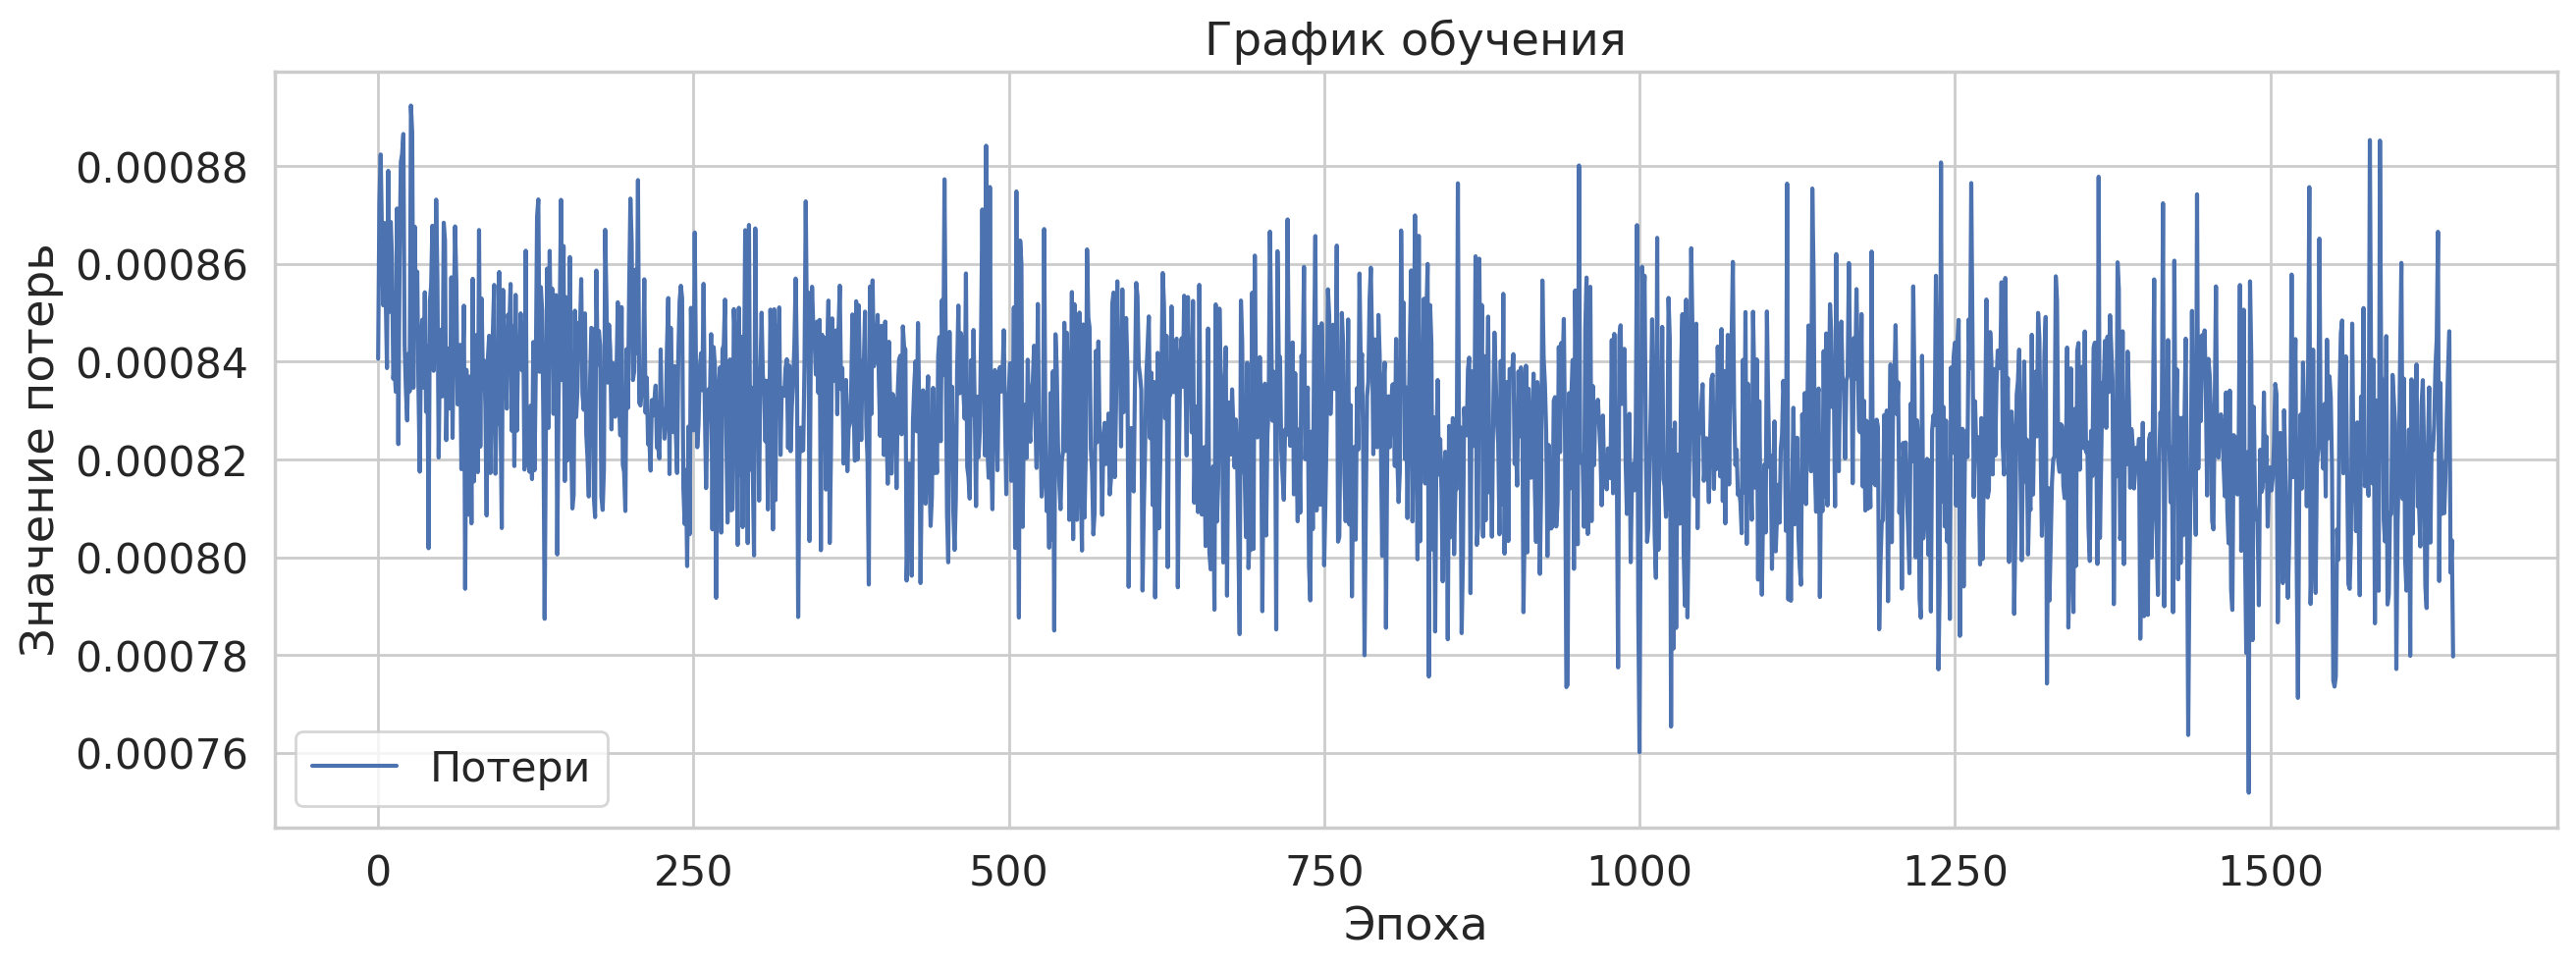

In [13]:
import torch
import torch.nn as nn
import torch_geometric.nn as gnn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns

sns.set(font_scale=1.4, style="whitegrid")
%config InlineBackend.figure_format='retina'

import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy("file_system")

from dataset import SEEDIVDataset, AsyncBatchLoader

# Установка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

sns.set(font_scale=1.4, style="whitegrid")
figure_format = "retina"


class DCGRU(nn.Module):
    def __init__(self, input_dim, hiden_dim, K, normalization="sym"):
        super().__init__()
        self.input_dim = input_dim
        self.hiden_dim = hiden_dim
        self.K = K

        self.reset_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)
        self.update_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)
        self.mem_conv = gnn.ChebConv(
            input_dim + hiden_dim, hiden_dim, K, normalization
        ).to(device)

        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, edge_idx, edge_attr):
        hiden = torch.zeros(x[0].shape[0], self.hiden_dim).to(device)

        for x_item, edge_item, attr_item in zip(x, edge_idx, edge_attr):

            x_item = x_item.to(device)
            edge_item = edge_item.to(device)
            attr_item = attr_item.to(device)

            combined = torch.cat((x_item, hiden), dim=1)

            # Reset gate
            r = self.sigmoid(self.reset_conv(combined, edge_item, attr_item))

            # Update gate
            u = self.sigmoid(self.update_conv(combined, edge_item, attr_item))

            # Memory candidate
            c = self.tanh(
                self.mem_conv(
                    torch.cat((x_item, r * hiden), dim=1), edge_item, attr_item
                )
            )

            hiden = u * hiden + (1 - u) * c

        return hiden


class EmoClassifaer(nn.Module):
    def __init__(
        self, num_classes, num_nodes, input_dim, hiden_dim, K, normalization="sym"
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.dcgru = DCGRU(input_dim, hiden_dim, K, normalization).to(device)
        self.net = nn.Sequential(
            nn.Linear(hiden_dim * num_nodes, 1024).to(device),
            nn.ReLU(),
            nn.Linear(1024, num_classes).to(device),
        )

    def forward(self, x, edge_idx, edge_attr):
        hiden = self.dcgru(x, edge_idx, edge_attr)
        batch = torch.stack(torch.split(hiden, self.num_nodes, dim=0), dim=0)
        input = torch.flatten(batch, start_dim=1)
        return torch.softmax(self.net(input), dim=1)


if __name__ == "__main__":
    # Инициализация датасета и загрузчика
    dataset = SEEDIVDataset("data/coo_optim.zarr", group_shape=(20, 62, 10))
    print(len(dataset))
    loader = DataLoader(
        dataset,
        batch_size=62,
        shuffle=True,
        num_workers=0
    )

    loader_size = len(loader)

    loader = AsyncBatchLoader(loader)
    processes =  loader.start_workers(num_workers=4)

    model = EmoClassifaer(4, 62, 10, 20, 5).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss().to(device)

    losses = []

    for _ in tqdm(np.arange(loader_size), desc="Обучение"):

        batch = loader.get_batch()

        x_batch = [data.x.to(device) for data in batch[0]]
        idx_batch = [data.edge_index.to(device) for data in batch[0]]
        attr_batch = [data.edge_attr.to(device) for data in batch[0]]
        labels = batch[1].to(torch.long).to(device)

        optimizer.zero_grad()

        outputs = model(x_batch, idx_batch, attr_batch)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        losses.append(loss.item() / len(loader))

    torch.save(
        {
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        },
        "emo_classifier.pth",
    )

    for process in processes:
        process.join()

    # Визуализация потерь
    plt.figure(figsize=(15, 5))
    plt.plot(np.arange(len(losses)), losses, label="Потери")
    plt.xlabel("Эпоха")
    plt.ylabel("Значение потерь")
    plt.title("График обучения")
    plt.legend()
    plt.savefig("training_plo t.png", dpi=300, bbox_inches="tight")
    plt.close()
